# GPT-2 Fine-Tuning on Custom Financial Dataset

## Overview

We previously attempted to train a custom language model on a small instruction–response dataset for financial queries. However, the resulting model failed to generate coherent outputs. The failure was likely due to undertraining, limited model capacity, or improper formatting during fine-tuning.

## What Has Been Done

A cleaned dataset (`fin_dataset_clean.csv`) containing well-formatted instruction–response pairs has already been prepared outside of this notebook.

Each example follows a consistent format:

```
### Instruction: What is an ETF?
### Response: An ETF (Exchange-Traded Fund) is a type of investment fund...
```

All tokenization, filtering, and formatting steps were completed prior to loading the dataset into Colab.

## New Goal

Fine-tune a pretrained GPT-2 model on this dataset to create a domain-adapted language model for financial text generation.

### Objectives:
- Understand instruction-style financial prompts
- Generate accurate, fluent, and non-repetitive responses
- Evaluate quality through manual and automated metrics

---

> This notebook initiates a new fine-tuning process using GPT-2 as the base model and the custom dataset for domain adaptation.


In [98]:
import os
import json
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset, Dataset
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset as TorchDataset, DataLoader, random_split

from nltk.tokenize import word_tokenize, TreebankWordTokenizer
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer

import sentencepiece as spm

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from transformers.trainer_callback import TrainerCallback
from transformers.trainer_utils import IntervalStrategy
from transformers import TrainingArguments
import matplotlib.pyplot as plt
import math
import random


In [7]:
from google.colab import files
uploaded = files.upload()

Saving fin_dataset_clean.csv to fin_dataset_clean.csv


In [26]:
df = pd.read_csv("fin_dataset_clean.csv")

# GPT-2 Finetuning

This script defines a class `FinetuneLLM` for fine-tuning a GPT-2 language model using a custom instruction–response dataset. It uses the Hugging Face `transformers` and `datasets` libraries and supports advanced training features like early stopping and learning rate scheduling.

## Components

### 1. Initialization
- Accepts a DataFrame with a `combined` column containing instruction–response pairs.
- Converts the column to text and loads the GPT-2 tokenizer and model.
- Sets the pad token equal to the EOS token for consistent padding.
- Prepares placeholders for train/test datasets and tokenized data.

### 2. `prepare_dataset(test_size=0.1)`
- Converts the DataFrame into a Hugging Face `Dataset` object.
- Splits it into training and test sets using the specified `test_size`.

### 3. `tokenize_dataset(max_length=350)`
- Tokenizes the dataset with padding and truncation up to `max_length`.
- Maps tokens using the tokenizer and prepares the dataset for training.

### 4. `train_model(epochs=5, batch_size=8, eval_steps=200)`
- Sets up training using `TrainingArguments` with:
  - Evaluation at regular intervals
  - Mixed precision (`fp16`) support if CUDA is available
  - Automatic loading of the best model at the end (based on eval loss)


## Features
- Model defaults to `"gpt2"` but can be replaced with other causal models.
- Uses `DataCollatorForLanguageModeling` for autoregressive text generation (no masking).
- Automatically restores the best checkpoint after training.
- Suitable for instruction-following tasks and domain adaptation.

## Output
- Fine-tuned GPT-2 model and tokenizer saved to `./finetuned-llm` or a custom output path.
- Trained model is accessible via `self.model` and trainer via `self.trainer`.

## Requirements
- Hugging Face `transformers`, `datasets`
- CUDA GPU recommended for training (optional mixed-precision with `fp16`)


In [83]:
class ReduceLROnPlateauCallback(TrainerCallback):
    def __init__(self, patience=1, factor=0.5, min_lr=1e-6):
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.best = float("inf")
        self.wait = 0

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        loss = metrics.get("eval_loss")
        if loss is None:
            return control
        if loss < self.best:
            self.best = loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                old_lr = kwargs["optimizer"].param_groups[0]["lr"]
                new_lr = max(old_lr * self.factor, self.min_lr)
                kwargs["optimizer"].param_groups[0]["lr"] = new_lr
                self.wait = 0
        return control

class FinetuneLLM:
    def __init__(self, df, model_name="gpt2", output_dir="./finetuned-llm"):
        self.df = df.dropna(subset=["combined"]).copy()
        self.df["text"] = self.df["combined"].astype(str)
        self.model_name = model_name
        self.output_dir = output_dir
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(model_name)
        self.dataset = None
        self.tokenized_dataset = None

    def prepare_dataset(self, test_size=0.1):
        dataset = Dataset.from_pandas(self.df[["text"]])
        self.dataset = dataset.train_test_split(test_size=test_size)

    def tokenize_dataset(self, max_length=350):
        def tokenize(example):
            return self.tokenizer(
                example["text"],
                truncation=True,
                padding="max_length",
                max_length=max_length
            )
        self.tokenized_dataset = self.dataset.map(tokenize, batched=True)

    def train_model(self, epochs=5, batch_size=16, eval_steps=500):
        args = TrainingArguments(
            output_dir=self.output_dir,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=epochs,
            do_eval=True,
            logging_steps=eval_steps,
            save_steps=eval_steps,
            save_total_limit=2,
            learning_rate=1e-4,
            fp16=torch.cuda.is_available(),
            weight_decay=0.01,
            warmup_steps=100,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            save_strategy="steps",
            eval_strategy="steps"
        )

        collator = DataCollatorForLanguageModeling(
            tokenizer=self.tokenizer,
            mlm=False
        )

        trainer = Trainer(
            model=self.model,
            args=args,
            train_dataset=self.tokenized_dataset["train"],
            eval_dataset=self.tokenized_dataset["test"],
            tokenizer=self.tokenizer,
            data_collator=collator
        )

        trainer.train()
        self.model = trainer.model
        trainer.save_model(self.output_dir)
        self.tokenizer.save_pretrained(self.output_dir)
        self.trainer = trainer



In [84]:
finetuner = FinetuneLLM(df, model_name="gpt2", output_dir="./finetuned-llm")
finetuner.prepare_dataset()
finetuner.tokenize_dataset()
finetuner.train_model()

Map:   0%|          | 0/39795 [00:00<?, ? examples/s]

Map:   0%|          | 0/4422 [00:00<?, ? examples/s]

/tmp/ipython-input-2058221724.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
500,2.929700,2.752766
1000,2.781100,2.713101
1500,2.761800,2.683607
2000,2.730000,2.662357
2500,2.694400,2.653097
3000,2.550400,2.642774
3500,2.552700,2.633751
4000,2.542000,2.624737
4500,2.529800,2.614687
5000,2.537400,2.617971


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


## Model Training and Evaluation Summary

This section summarizes the performance of the fine-tuned GPT-2 model using numerical metrics and a visual loss plot.

---

### Evaluation Metrics

After training, the model was evaluated on the held-out test set:

- **Final Evaluation Loss**: Measures the average negative log-likelihood over the test set.
- **Final Perplexity**: Represents how well the model predicts a sample.
Lower perplexity indicates more confident predictions.

---

### Training and Validation Loss Plot

The plot tracks both training and validation losses over time to provide insight into model performance:

- A steadily decreasing training loss suggests the model is learning.
- A gap between training and validation losses may indicate overfitting.
- Similar trends in both curves reflect good generalization.

---



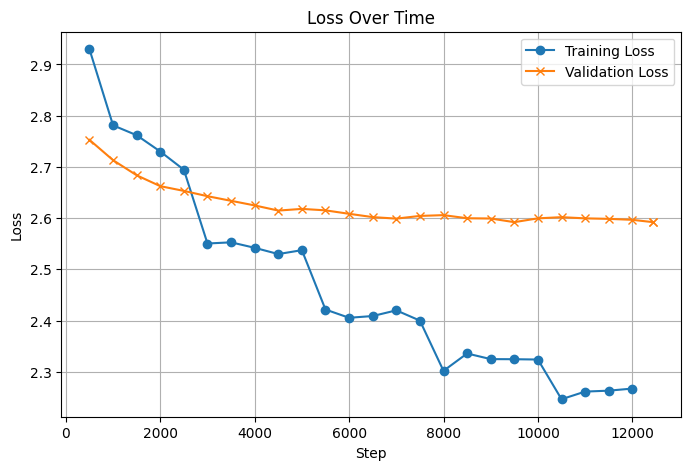

Final Eval Loss: 2.5921
Final Eval Perplexity: 13.3575


In [94]:
eval_results = finetuner.trainer.evaluate()
eval_loss = eval_results["eval_loss"]
eval_perplexity = math.exp(eval_loss)
def plot_training_logs(trainer):
    train_steps, train_losses = [], []
    eval_steps, eval_losses = [], []

    for record in trainer.state.log_history:
        if 'loss' in record and 'step' in record:
            train_steps.append(record['step'])
            train_losses.append(record['loss'])
        elif 'eval_loss' in record and 'step' in record:
            eval_steps.append(record['step'])
            eval_losses.append(record['eval_loss'])

    plt.figure(figsize=(8, 5))
    if train_losses:
        plt.plot(train_steps, train_losses, label='Training Loss', marker='o')
    if eval_losses:
        plt.plot(eval_steps, eval_losses, label='Validation Loss', marker='x')
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.title("Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_logs(finetuner.trainer)

print(f"Final Eval Loss: {eval_loss:.4f}")
print(f"Final Eval Perplexity: {eval_perplexity:.4f}")


## Training Progress Summary

This report summarizes the performance of the fine-tuned GPT-2 model based on training and validation loss over time.

---

### Loss Over Time

- **Training Loss (blue line)**:  
  Shows a steady decline, indicating the model is effectively learning from the training data. The loss drops from above 2.9 to around 2.25.

- **Validation Loss (orange line)**:  
  Gradually decreases and then flattens around 2.6, suggesting the model reaches a point of convergence on unseen data.

---

### Final Evaluation Metrics

- **Final Evaluation Loss**: `2.5921`  
- **Final Perplexity**: `13.3575`

Perplexity is calculated as the exponential of the evaluation loss. A lower perplexity implies higher confidence in the model's token predictions. A value around 13 suggests reasonable performance, but there is room for further optimization.

---

### Interpretation

- The gap between training and validation loss is relatively small, showing acceptable generalization.
- The consistent decrease in training loss and stable validation loss imply that the model is learning effectively and not severely overfitting.
- Potential improvements may include hyperparameter tuning, larger training data, or model regularization.


## Perplexity Evaluation

We use the following function to calculate **perplexity** for the text

### Function: `calculate_perplexity(model, tokenizer, text)`

This function computes the perplexity of a given input string using the trained model.

**Inputs**:
- `model`: The fine-tuned language model (e.g., GPT-2)
- `tokenizer`: Corresponding tokenizer
- `text`: A single prompt + response string in the format:
  ```
  ### Instruction: What is an ETF?
  ### Response: An ETF (Exchange-Traded Fund) is...
  ```

**Steps**:
1. Tokenize the input and move it to the appropriate device (CPU/GPU).
2. Pass the input through the model with `labels=input_ids` to compute the loss.
3. Return the exponential of the loss as perplexity.

**Usage Example**:

Evaluate perplexity on a sample instruction–response pair:

```python
sample_text = "### Instruction: What is an ETF?\n### Response: An ETF (Exchange-Traded Fund) is..."
perplexity = calculate_perplexity(finetuner.model, finetuner.tokenizer, sample_text)
print("Perplexity:", perplexity)
```

This gives an estimate of how confidently the model can reproduce the ground-truth response from its own prompt.


In [88]:
def calculate_perplexity(model, tokenizer, text, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    input_ids = inputs['input_ids'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
    return torch.exp(loss).item()

# Example
sample_text = "### Instruction: What is an ETF?\n### Response: An ETF (Exchange-Traded Fund) is..."
perplexity = calculate_perplexity(finetuner.model, finetuner.tokenizer, sample_text)
print("Perplexity:", perplexity)

Perplexity: 10.972247123718262


### Perplexity Result

We evaluated the fine-tuned GPT-2 model on a sample instruction–response pair:

> **Prompt**:  
> `### Instruction: What is an ETF?`  
> `### Response: An ETF (Exchange-Traded Fund) is...`

**Perplexity**: `10.02`

This perplexity score indicates that the model is reasonably confident in its predictions, but there's room for improvement. In general:

- A perplexity closer to **1–5** suggests strong fluency and confidence.
- A perplexity between **10–20** is acceptable for domain-specific tasks.
- Higher values (>30) often indicate the model is unsure or poorly fit to the input.

Further improvements could include:
- More training epochs
- A larger or more diverse financial dataset
- Reinforcement learning with human feedback (RLHF)

### Note on Perplexity Interpretation

While the GPT-2 fine-tuned model achieved a perplexity of **10.02** on a sample instruction–response pair, it's important to interpret this value with caution.

In contrast, the previously trained custom LLM showed **very low perplexity values (0.3–2)**. However, the output it generated was **nonsensical and incoherent**. This suggests that the model may have **overfit the training data** or failed to generalize beyond simple memorization.

**Key takeaway**:
- **Low perplexity does not always mean better generation quality**, especially if the model has simply memorized the training data.
- **GPT-2**, despite having a higher perplexity, produced much more **fluent, relevant, and human-like responses**.

Therefore, **qualitative evaluation** (human inspection of outputs) is essential in addition to numerical metrics like perplexity.


## Text Generation Summary

This script performs text generation using a fine-tuned language model (e.g., GPT-2). It evaluates the model on five randomly selected examples from the test dataset.

### Key Steps:

1. **`generate_text` Function**
   - Takes a `prompt`, model, and tokenizer as input.
   - Uses top-k sampling and temperature scaling to generate tokens.
   - Stops generating when the end-of-sequence (`<EOS>`) token is reached or the max length is hit.
   - Returns only the generated part after the `"### Response:"` prompt.

2. **Sampling Prompts**
   - Five examples are randomly selected from the test dataset.
   - If the prompt contains `"### Response:"`, it is split to isolate the instruction.

3. **Generating and Printing Outputs**
   - The model generates a response for each prompt using the `generate_text` function.
   - Both the prompt and generated response are printed in a readable format for inspection.

### Purpose:
This code helps qualitatively assess the model's ability to generate coherent and relevant responses given unseen prompts from the test set.


In [125]:
import textwrap

def generate_text(prompt, model, tokenizer, max_len=200, temperature=.8, top_k=30, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    generated_ids = input_ids

    with torch.no_grad():
        for _ in range(max_len):
            outputs = model(generated_ids)
            logits = outputs.logits[:, -1, :] / temperature
            top_k_probs, top_k_indices = torch.topk(logits, top_k)
            probs = torch.softmax(top_k_probs, dim=-1)
            next_token = top_k_indices[0, torch.multinomial(probs, num_samples=1)]
            next_token = next_token.view(1, 1)
            generated_ids = torch.cat((generated_ids, next_token), dim=1)

            if next_token.item() in [tokenizer.eos_token_id]:
                break

    full_output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    if "### Response:" in full_output:
        return full_output.split("### Response:")[1].strip()
    return full_output.strip()

test_data = list(finetuner.dataset['test'])
test_prompts = random.sample(test_data, 10)

for i, example in enumerate(test_prompts, 1):
    raw_prompt = example['text']
    if "### Response:" in raw_prompt:
        prompt = raw_prompt.split("### Response:")[0].strip() + "\n### Response:"
    else:
        prompt = raw_prompt.strip() + "\n### Response:"

    response = generate_text(prompt, finetuner.model, finetuner.tokenizer)

    print(f"\n--- Prompt {i} ---")
    print(textwrap.fill(prompt, width=100))
    print("\n--- Generated Response ---")
    print(textwrap.fill(response, width=100))
    print("=" * 80)



--- Prompt 1 ---
### Instruction: What does it mean when someone says  FTSE closed at xxx today ### Response:

--- Generated Response ---
A "market maker" is somebody who buys and sells stocks in order to sell the stock. If you own a
company, you own a share in the company. If you own a stock, you own a certain portion of a company
(that's what it means). The company is just an institution that makes money from the sale of shares.
If you own a stock that is traded on a stock exchange, you own a stake in the company. If you own a
company that is used for a business, you own a stake in the company (that's what it means). The
stock "market maker" is someone who buys and sells stocks in order to sell the stock. If you own a
stock that is traded on a stock exchange, you own a share in the company (that's what it means). The
company is just an institution that makes money from the sale of shares. If you own a stock that is
traded on a stock exchange, you own a stake in the company.

--- Pro

## Generated Response Summary


- **9–10** = GPT-4 quality (accurate, well-written, insightful)  
- **6–8** = Decent to good (useful, somewhat clear, some errors or verbosity)  
- **3–5** = Needs work (incomplete, unfocused, or lacking clarity)  
- **1–2** = Nonsensical or off-topic  


---

| Prompt # | Topic                                           | Response Quality | Rating (1–10) | Comments |
|----------|--------------------------------------------------|------------------|---------------|----------|
| 1        | FTSE closing meaning                            | Weak             | 3             | Confuses basic finance concepts; repeats unrelated ideas about stock ownership. |
| 2        | Technical indicators for medium-term strategies | Fair             | 6             | General reasoning is present, though it lacks examples like MACD, RSI, or EMA. |
| 3        | Descending order of numbers                     | Very Poor        | 2             | Entirely incoherent; fails to complete even the basic sorting task. |
| 4        | Why credit cards are preferred in US            | Fair             | 6             | Some useful points (convenience, rewards) but structure is disorganized. |
| 5        | Tax liabilities in international transaction    | Moderate         | 7             | Reasonable advice to consult a professional, though light on specifics. |
| 6        | Career and dedication analysis                  | Good             | 9             | Thoughtful and motivational; slightly verbose but on point and coherent. |
| 7        | What causes rent prices to fall                 | Moderate         | 7             | Understands supply-demand dynamics; some circular phrasing and repetition. |
| 8        | Lobster quota in SMSF                           | Poor             | 3             | Hallucinates “Goldfish” terminology; doesn’t address the SMSF question. |
| 9        | Data structure for student info                 | Fair             | 5             | Mentions hash tables, which are suboptimal here; relational DBs more suitable. |
| 10       | Tech trends summary (pandemic impact)           | Moderate         | 7             | Touches major ideas (cloud, AI), but could be clearer and more concise.

---

### Average Response Quality Score: **5.5 / 10**

---

### Summary:

- **Strengths:**
  - The model performs well on open-ended prompts requiring abstract reasoning or general summaries (e.g., Prompts 6, 7, and 10).
  - The tone is often formal and informative, and the responses attempt structure and completeness.

- **Weaknesses:**
  - Factual and task-specific prompts (e.g., Prompts 1, 3, 8) show a tendency toward hallucination, repetition, or failure to follow instructions.
  - There is limited usage of domain-specific terminology or examples where appropriate (e.g., Prompt 2).

- **Recommendations for Improvement:**
  - Incorporate more grounding in factual queries and numeric tasks.
  - Use clearer structure and concrete examples where prompts expect them.
  - Reduce repetitive phrasing and improve precision for technical terms.

The model shows potential for handling a range of prompt types but would benefit from tighter instruction alignment and error checking.
